## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## preparation

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pickle
import cv2
import glob

%matplotlib inline

# plot input vs output side by side
# note that imshow expects rgb img, if you have bgr img, please 
# convert before using this one, example code is the following:
# rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

def plot_two_imgs(left_img, right_img, left_cmap=None, right_cmap=None, left_title = "left img", right_title= "right img", ):
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(left_img, cmap=left_cmap)
    ax1.set_title(left_title, fontsize=50)
    ax2.imshow(right_img, cmap=right_cmap)
    ax2.set_title(right_title, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



## First, I'll compute the camera calibration using chessboard images

In [2]:
# calibrate camera using collection of chessboard pictures. 
# Note: 
# 1. calibration will not happen if found coners less than half of the checkboard images 
# 2. Same image size for the correlation image and future image to be undistorted
# images_path: input file name patterns, default value:camera_cal/calibration*.jpg
# corner_num_x: number of corners along the x axis, default value:9
# corner_num_y: number of corners along the y axis, default value:6
# output_path:  output the corner found images for debugging purpose. default value:"camera_cal_output"
# img_size: this corresponds to the picture to be undistorted. default value: None, use the calibration img size
#
# The size of the image, which is passed into the calibrateCamera function, is just the height and width of the image.
# One way to retrieve these values is by retrieving them from the grayscale image shape array gray.shape[::-1]. 
# This returns the image width and height in pixel values like (1280, 960).
# Another way to retrieve the image shape, is to get them directly from the color image by retrieving the first two 
# values in the color image shape array using img.shape[1::-1]. This code snippet asks for just the first two values 
# in the shape array, and reverses them. Note that in our case we are working with a greyscale image, 
# so we only have 2 dimensions (color images have three, height, width, and depth), so this is not necessary.

# Return value - same as cv2.calibrateCamera return
# plus result saved to <output_path>/cam_calibration_result_pickle.p for future use
 

def calibrate_camera (images_path="camera_cal/calibration*.jpg", corner_num_x=9, corner_num_y=6, output_path="camera_cal_output/", img_size=None):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((corner_num_y*corner_num_x,3), np.float32)
    objp[:,:2] = np.mgrid[0:corner_num_x, 0:corner_num_y].T.reshape(-1,2)

    # Make a list of calibration images
    images = glob.glob(images_path)


    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in img plane

    # prepare output file dir
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # Step through the list and search for chessboard corners
    corners_found = 0
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (corner_num_x,corner_num_y), None)

        # If found, add object points, image points
        if ret == True:
            corners_found += 1
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (corner_num_x,corner_num_y), corners, ret)
            write_name = output_path+'corners_found_in_'+os.path.basename(fname)
            cv2.imwrite(write_name, img)
            print ("corners found and saved as:" + write_name)

        else:
            print ("coners not found in: " + fname)
       
    
    if corners_found > idx / 2:
        print ("OK: found cornders in more than half of the input images, carry on with calibration")
        if img_size is None:
            img_size = (img.shape[1], img.shape[0])
            print("img_size is None, use calibration img size: " + str(img_size))
            
            
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
        
        # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
        dist_pickle = {}
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        cam_calibration_result = output_path+"cam_calibration_result_pickle.p"
        pickle.dump( dist_pickle, open( cam_calibration_result, "wb" ) )
        
        print("camera calibration result saved in file " + cam_calibration_result + " for future use" )
    
        return ret, mtx, dist, rvecs, tvecs
        
    else:
        print ("Error: found cornders in less than half of the input images, stopped calibration.")
        return -1, None, None, None, None



##  Note of Applying a distortion correction to raw images.
No wrapping code needed. please use cv2.undistort directly in the future pipeline.
Example code below: 

In [3]:
# Read in the saved camera matrix and distortion coefficients from the pickle dump file
# dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
# mtx = dist_pickle["mtx"]
# dist = dist_pickle["dist"]
# Use the OpenCV undistort() function to remove distortion
# undist = cv2.undistort(img, mtx, dist, None, mtx)

## Then, Use color transforms, gradients, etc., to create a thresholded binary image

In [4]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.

# the gray image color space has bad result with shadows, try 

def abs_sobel_thresh(gray_img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return grad_binary


# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(gray_img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return dir_binary

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(gray_img, sobel_kernel=3, thresh=(0, 255)):

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    

    # Return the binary image
    return mag_binary

# in HLS color space, the the S channel is still doing a fairly robust job of picking up the lines 
# under very different color and contrast conditions, which helps to  Reliably detect different colors 
# of lane lines under varying degrees of daylight and shadow.
def color_thresh(hls_img, s_thresh=(170, 255)):
    s_channel = hls_img[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    return s_binary

# a larger kernel size make it smoother
def combined_thresh(bgr_img, ksize=3, grad_thresh=(0, 255), magitude_thresh=(0, 255), dir_thresh=(0, np.pi/2)):
    
    # for plotting purpose.
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    hls_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HLS)


    # as input to various threshold 
    gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    

    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray_img, orient='x', sobel_kernel=ksize, thresh=grad_thresh)    
    #plot_two_imgs(left_img=gray_img, left_cmap='gray', right_img=gradx, right_cmap='gray', right_title = "gradx" )
        
    grady = abs_sobel_thresh(gray_img, orient='y', sobel_kernel=ksize, thresh=grad_thresh)
    #plot_two_imgs(left_img=gray_img, left_cmap='gray', right_img=grady, right_cmap='gray', right_title = "grady" )

    mag_binary = mag_thresh(gray_img, sobel_kernel=ksize, thresh=magitude_thresh)  
    #plot_two_imgs(left_img=gray_img, left_cmap='gray', right_img=mag_binary, right_cmap='gray', right_title = "mag" )

    dir_binary = dir_threshold(gray_img, sobel_kernel=ksize, thresh=dir_thresh)
    #plot_two_imgs(left_img=gray_img, left_cmap='gray', right_img=dir_binary, right_cmap='gray', right_title = "directional" )

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #plot_two_imgs(left_img=gray_img, left_cmap='gray', right_img=combined, right_cmap='gray', right_title = "combined" )


    # apply color
    s_binary = color_thresh(hls_img, (170, 255))
    #plot_two_imgs(left_img=hls_img, right_img=s_binary, right_title = "combined" )
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    # stacked_color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_with_color = np.zeros_like(combined)
    combined_with_color[(s_binary == 1) | (combined == 1)] = 1
    plot_two_imgs(left_img=rgb_img, right_img=combined_with_color, right_cmap='gray', right_title = "combined" )


    return combined_with_color


In [5]:

# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
# the img MUST be read in by cv2.imread()

# Note: Note: Make sure you use the correct grayscale conversion depending on how you've read in your images. 
# Use cv2.COLOR_RGB2GRAY if you've read in an image using mpimg.imread(). Use cv2.COLOR_BGR2GRAY if you've 
# read in an image using cv2.imread().

def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M




## Pipeline linking all processors

In [6]:
# detect lane from a image file
#




def adv_lane_detection_pipeline(initial_img_path, calibration_mtx, calibration_dist):
    img = cv2.imread(initial_img_path)
    img_size = (img.shape[1], img.shape[0])
    
    # Apply a distortion correction to raw imageg
    undist = cv2.undistort(img, calibration_mtx, calibration_dist, None, calibration_mtx)

    # Use color transforms, gradients, etc., to create a thresholded binary image.
    # experiment about the grad and magnitude threshold:
    # lower the L-threshold, more noise. should not be lower than 30, 50 looks good.
    # higher the H-threshold, brighter the line. nothing wrong with it. use 200. 
    
    thresholded = combined_thresh(undist, 15,(50,200),(50,200),(0.7,1.3))
    




    #(30,100)
    
    
    # Apply a perspective transform to rectify binary image ("birds-eye view").
    
    
    # Detect lane pixels and fit to find the lane boundary.
    
    
    # Determine the curvature of the lane and vehicle position with respect to center.
    
    
    # Warp the detected lane boundaries back onto the original image.
    
    
    # Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

    result = thresholded

    return result




coners not found in: camera_cal/calibration5.jpg
coners not found in: camera_cal/calibration4.jpg
corners found and saved as:camera_cal_output/corners_found_in_calibration6.jpg
corners found and saved as:camera_cal_output/corners_found_in_calibration7.jpg
corners found and saved as:camera_cal_output/corners_found_in_calibration3.jpg
corners found and saved as:camera_cal_output/corners_found_in_calibration2.jpg
coners not found in: camera_cal/calibration1.jpg
corners found and saved as:camera_cal_output/corners_found_in_calibration20.jpg
corners found and saved as:camera_cal_output/corners_found_in_calibration19.jpg
corners found and saved as:camera_cal_output/corners_found_in_calibration18.jpg
corners found and saved as:camera_cal_output/corners_found_in_calibration15.jpg
corners found and saved as:camera_cal_output/corners_found_in_calibration14.jpg
corners found and saved as:camera_cal_output/corners_found_in_calibration16.jpg
corners found and saved as:camera_cal_output/corners_foun

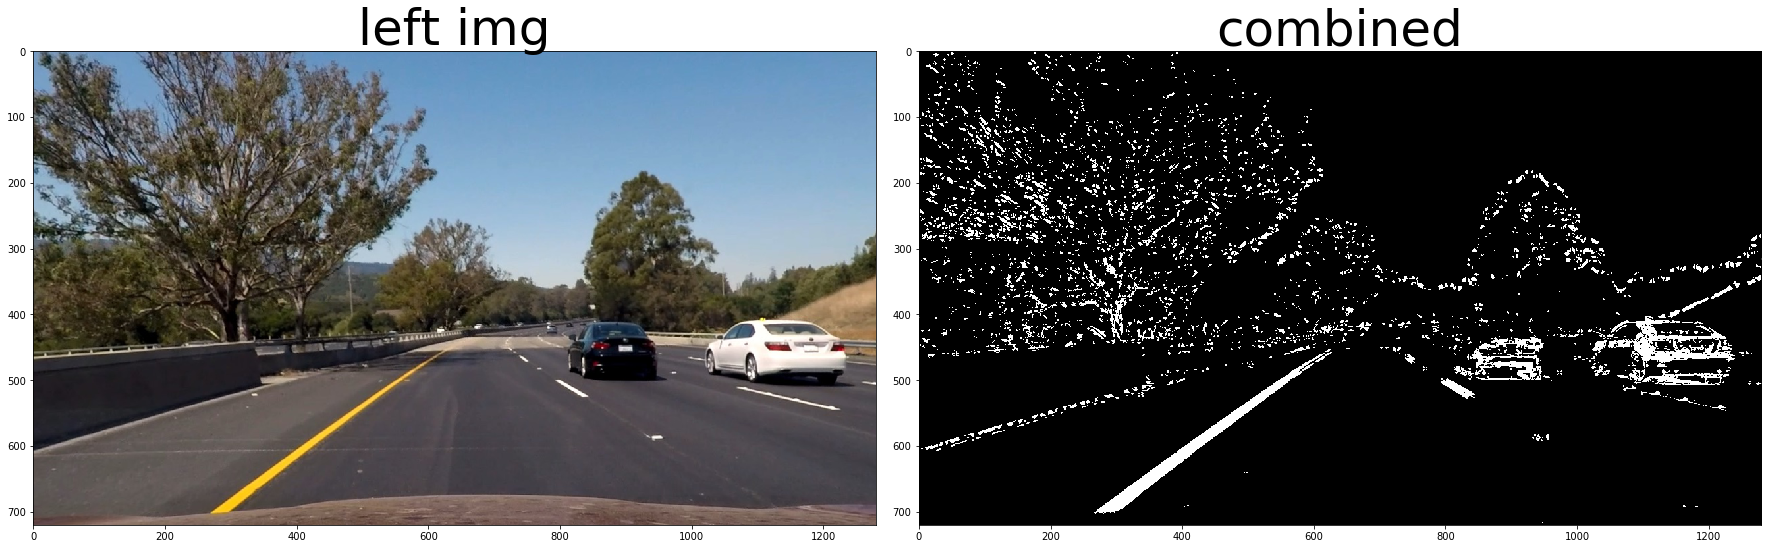

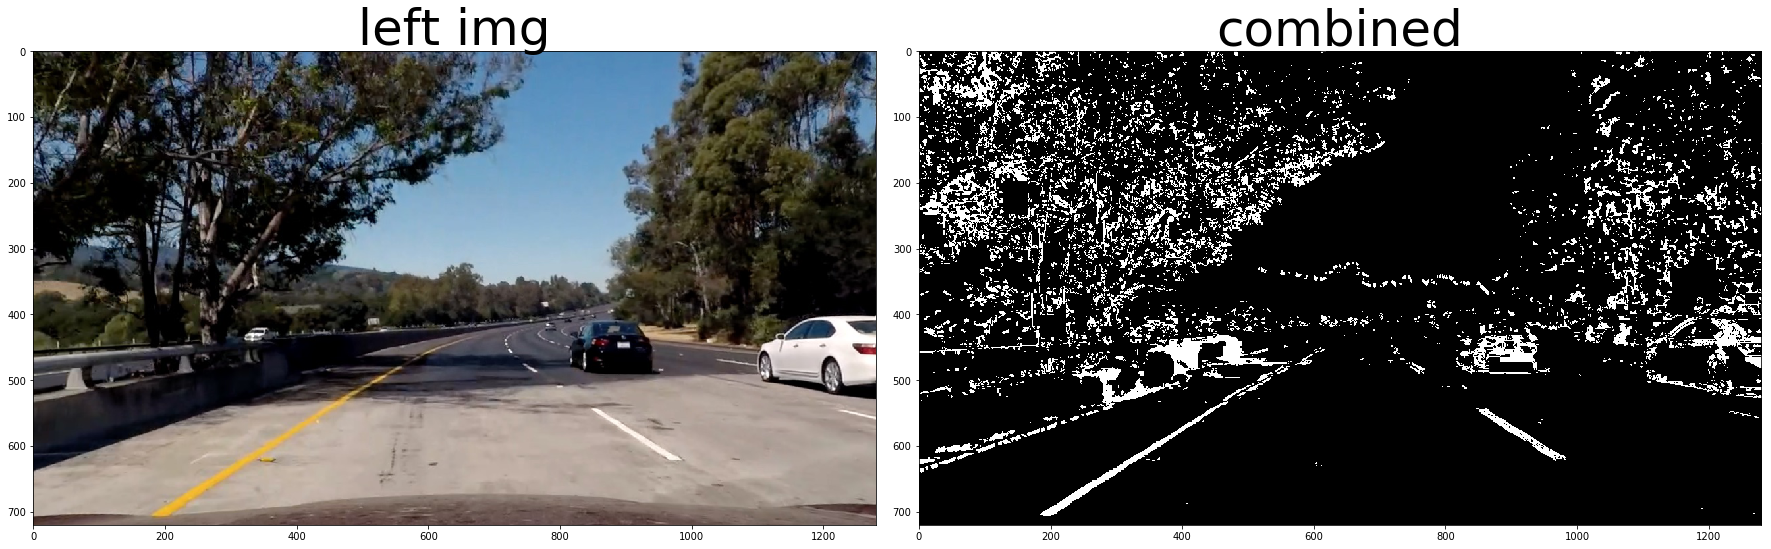

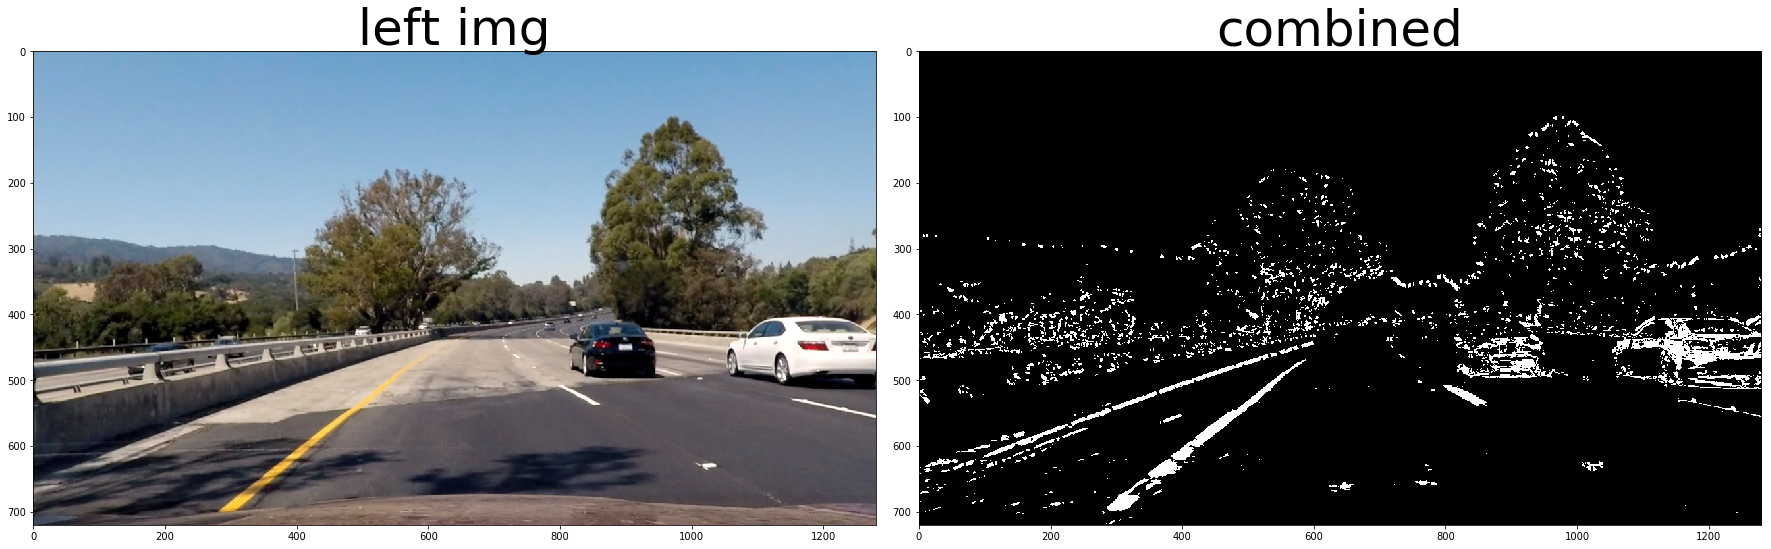

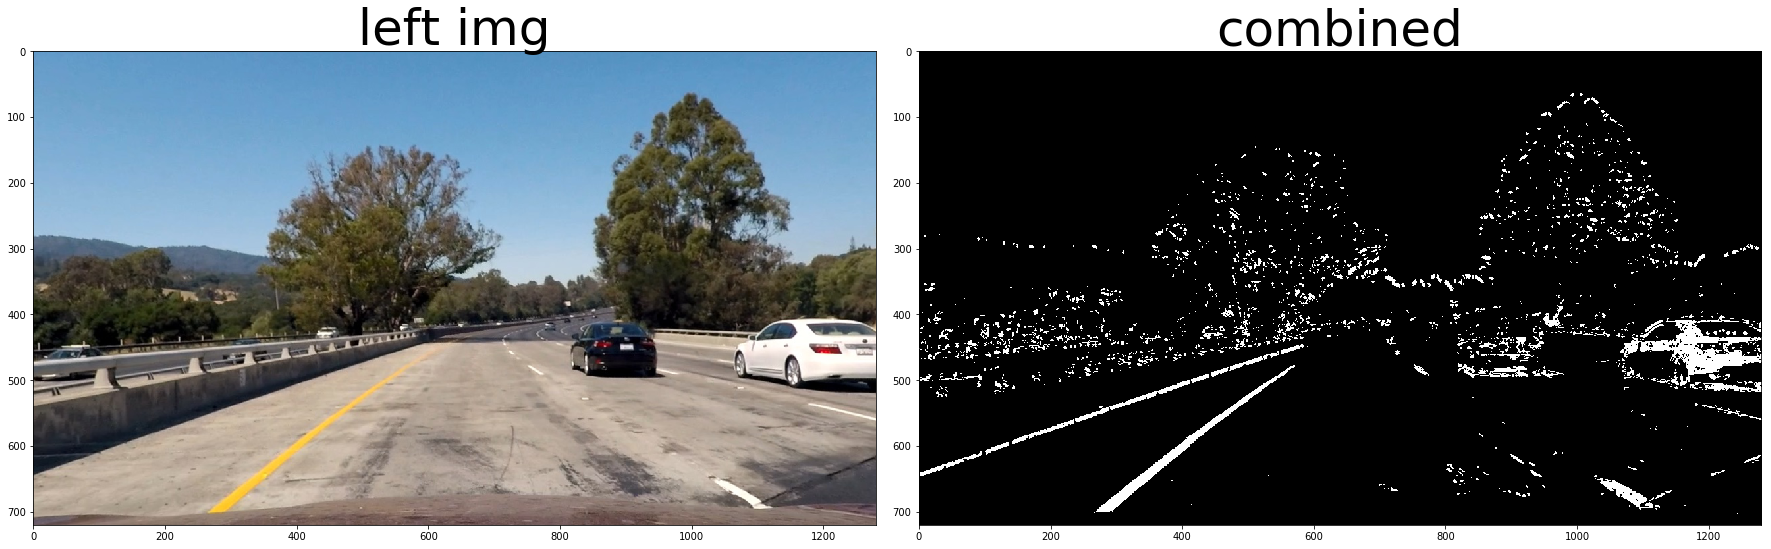

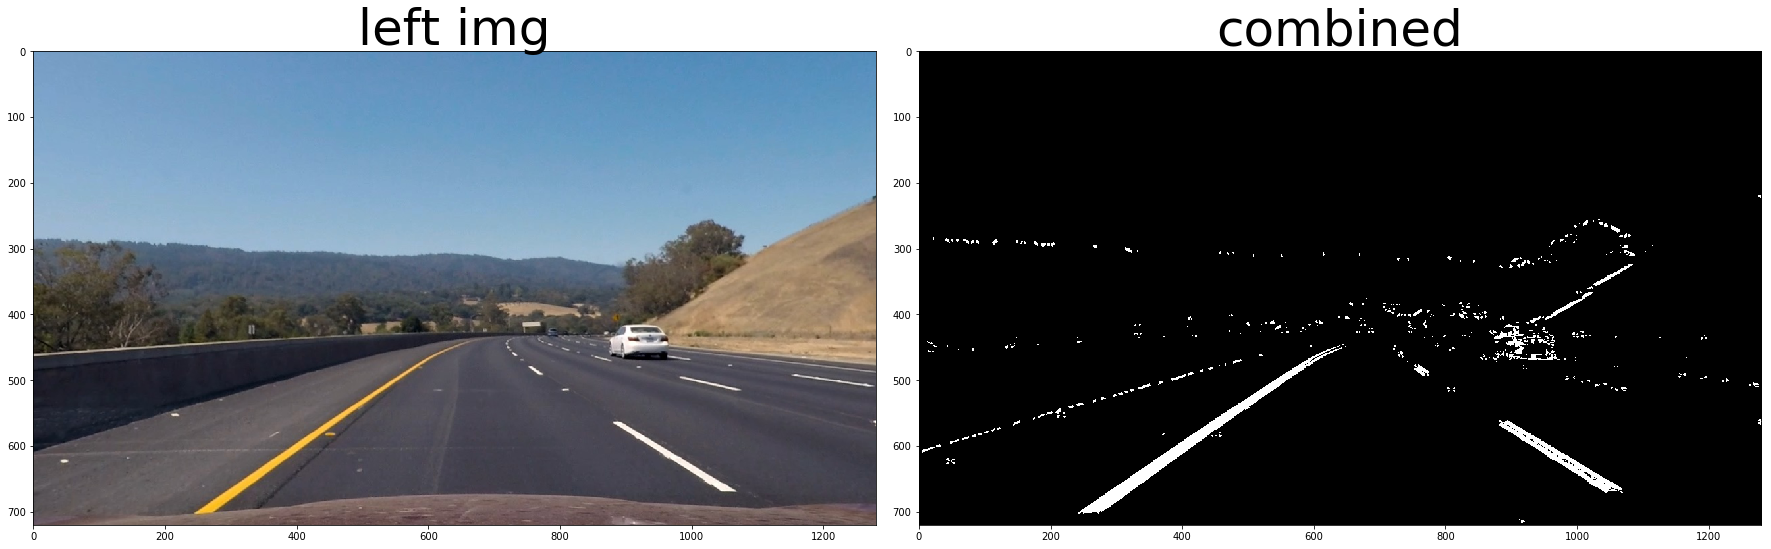

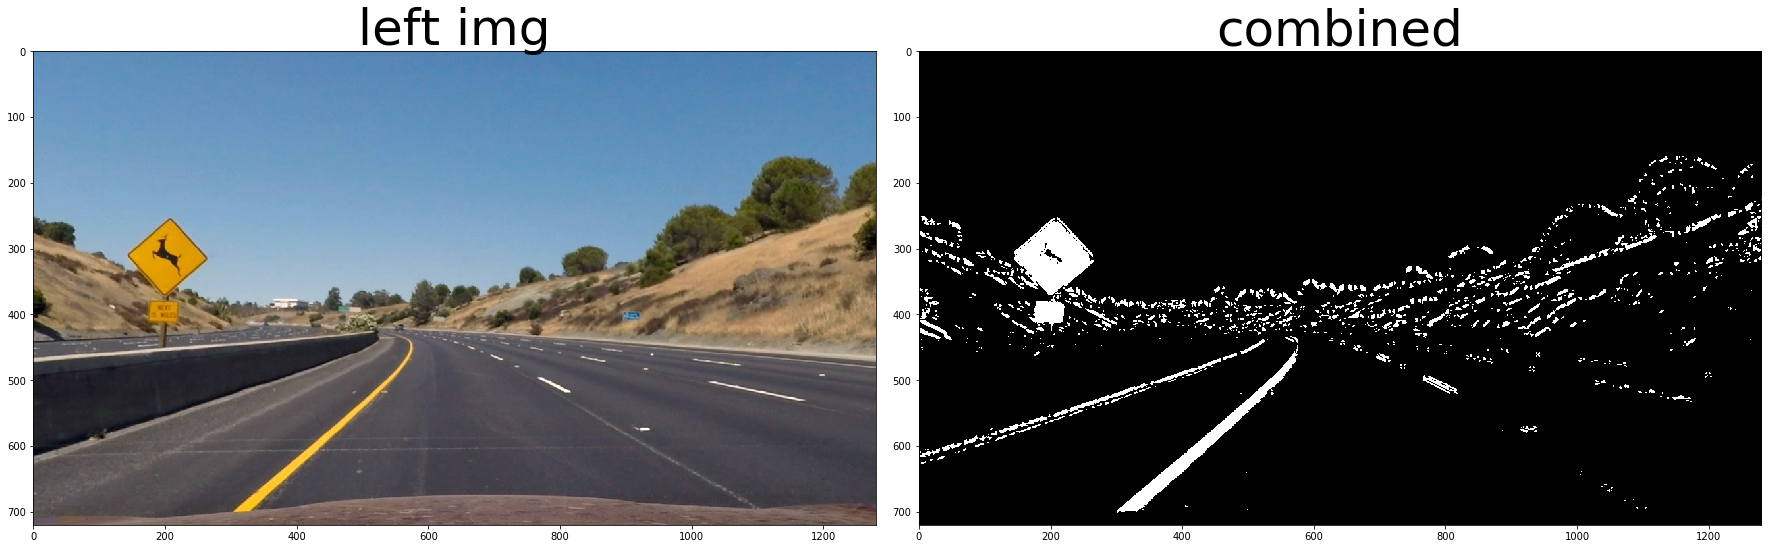

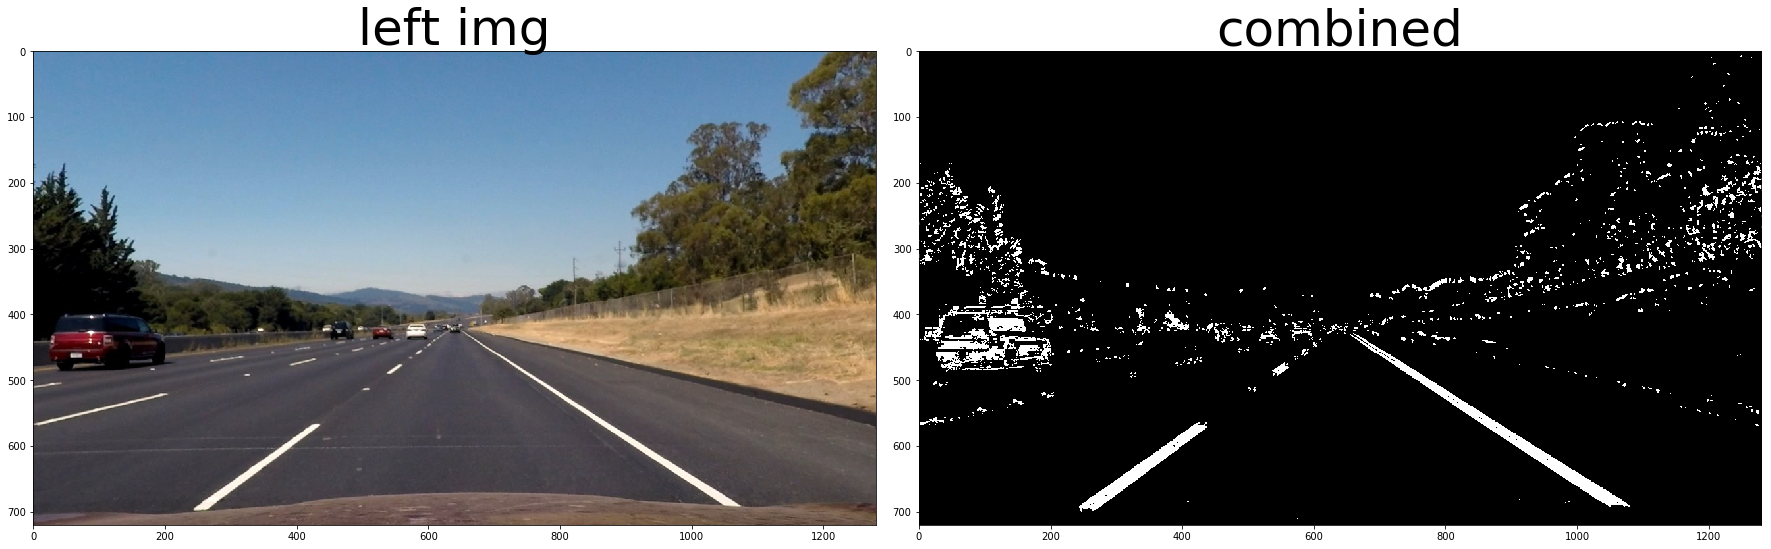

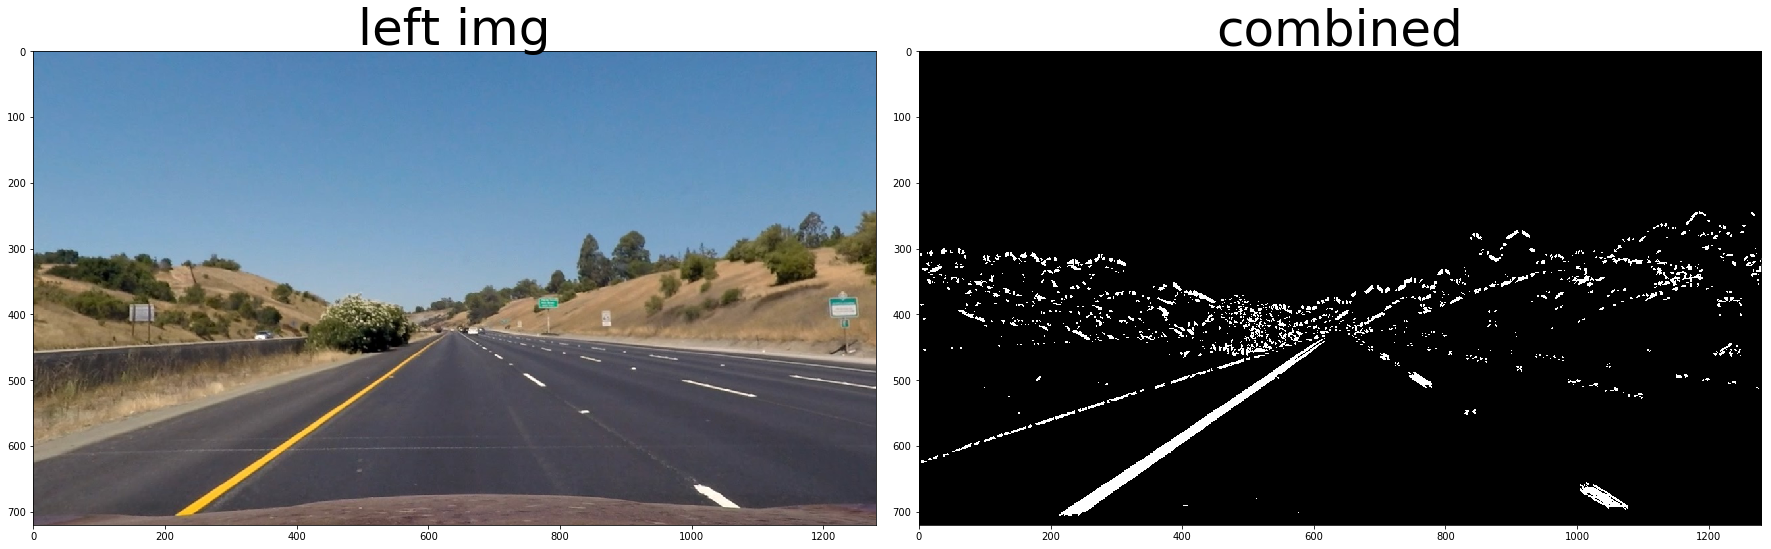

In [7]:
# Calibrate camera

ret, mtx, dist, rvecs, tvecs = calibrate_camera()
print(ret)

if ret < 0:
    print ("Error: calibration camera failed.")
    exit 

# iterate through every input file
INPUT_DIR = "test_images/"
OUTPUT_DIR = "test_images_output/"
os.makedirs(os.path.dirname(OUTPUT_DIR), exist_ok=True)

for filename in os.listdir(INPUT_DIR):    
    result_img = adv_lane_detection_pipeline (INPUT_DIR+filename, mtx, dist)
    cv2.imwrite(OUTPUT_DIR+filename, result_img)
    print("Processed img " + filename )
    # debug on, please remove below line, only do one img
    #break